# Comparision between sampling methods: Elliptical Slice Sampling vs Metropolis Hastings

In this notebook, I compare two samplers techniques, the  Elliptical Slice Sampling and Metropolis Hastings.

I genereta data from the a function compesed by two Gaussian function. Both methods are good to predict the behaviour of the data as show in the solid lines.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
from scipy.stats import multivariate_normal

In [ ]:
# Class for the Metropolis Hastings algorithm.

class MHastings:
    def __init__(self, xlist, target_prob, h, nsamp):

      self.xlist = xlist
      self.F = target_prob
      self.h = h
      self.nsamp = nsamp

      self._dim = self.nsamp
      self._samples = np.zeros(self._dim)
      self._samples[0] = 0


    def P(self, arg_1, arg_2):
      sigma_gauss = 1
      exp_arg = (arg_1 - arg_2)**2/sigma_gauss**2
      return -0.5*np.exp(exp_arg)/(math.sqrt(2*np.pi)*sigma_gauss)

    def estimation(self):
        acept = 0
        for i in range(0, self._dim-1):
            y = self._samples[i] + np.random.uniform(-self.h,self.h) # candidate point
            r = (self.F(y)*self.P(self._samples[i], y))/(self.F(self._samples[i])*self.P(y, self._samples[i]))
            if np.random.rand() < min(1, r):
                self._samples[i+1] = y
                acept += 1
            else:
                self._samples[i+1] = self._samples[i]
        return self._samples

In [ ]:
def mean_true(X, mean_value, sigma_value):
    argument_exp = -0.5*( x - mean_value )**2/sigma_value**2
    return np.exp(argument_exp)/(np.sqrt(2*math.pi*sigma_value**2))

def other(z):
  norm = 10.0261955464 # Normalized factor
  function = 3*np.exp(-z**2/2) + np.exp(-(z - 4)**2/2)
  return function/norm

In [ ]:
# Define the grid
x = np.linspace(-10, 10, 8000)

# Creation of mean vector which works as the observed data; mean_true -> equivalent to pdf_true
mu = 1.0
sigma = 0.1

In [ ]:
MH = MHastings(x, other, 0.5, int(1e5))

In [ ]:
prediction_mh = MH.estimation()

In [ ]:
# Save samples
np.savetxt('mh_estimation.txt', prediction_mh)
data_mh = np.loadtxt('mh_estimation.txt')

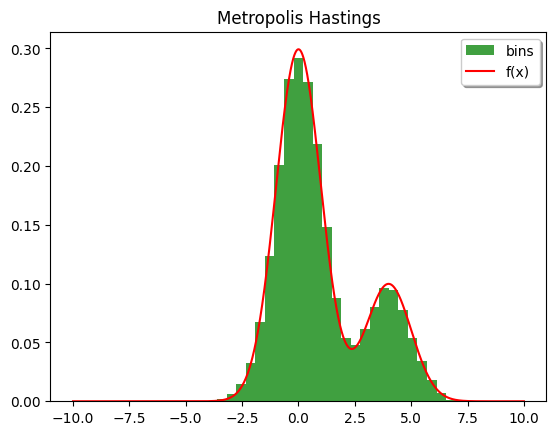

In [ ]:
plt.hist(data_mh, bins=25, histtype='bar', facecolor='g', alpha=0.75, density=True, label='bins')
plt.plot(x, other(x), 'r', label='f(x)')
plt.title('Metropolis Hastings')
plt.legend(loc='upper right', shadow=True)
plt.show()

In [ ]:
# Classs for the Elliptical Slice Sampler.

class EllipticalSlice:

    def __init__(self, nu_mean, nu_cov, loglike):

      self.nu_mean = nu_mean # prior mean
      self.nu_cov = nu_cov # prior cov
      self.loglike = loglike

    def main(self, f):
      nu = np.random.multivariate_normal(np.zeros(self.nu_mean.shape), self.nu_cov) # question: why It is centered at numpy zeros?
      log_y = self.loglike(f) + np.log(np.random.uniform())
      theta = np.random.uniform(0., 2.*np.pi)
      theta_min , theta_max = theta - 2.*np.pi , theta

      while True:
        f_prime = (f - self.nu_mean)*np.cos(theta) + nu*np.sin(theta) + self.nu_mean # question: why f -> (f - nu_mean) ?
        log_prime = self.loglike(f_prime)
        if log_prime > log_y:
          return f_prime
        else:
          if theta < 0:
            theta_min = theta
          else:
            theta_max = theta

          theta = np.random.uniform(theta_min, theta_max)

    def estimation(self, nsamp, burn_in = 1000):
      total_samp = nsamp + burn_in
      samples = np.zeros((total_samp, self.nu_cov.shape[0]))
      samples[0] = multivariate_normal(mean=self.nu_mean, cov=self.nu_cov).rvs() # question: It is the like the initial values?
      for i in range(1, total_samp):
        samples[i] = self.main(samples[i-1])
      return samples[burn_in:]

In [ ]:
# Prior arguments
mu_prior = 5.
sigma_prior = 1.

# Target distribution arguments
mu_targ = 1.
sigma_targ = 2.

# Due to the product of the gaussians we get the posterior's sigma and mu
mu_pos = ((sigma_prior**-2)*mu_prior + (sigma_targ**-2)*mu_targ) / ( sigma_prior**-2 + sigma_targ**-2)
sigma_pos = np.sqrt( (sigma_prior**2 * sigma_targ**2) / (sigma_prior**2 + sigma_targ**2))

def log_likelihood(f):
  return norm.logpdf(f, mu_targ, sigma_targ)

In [ ]:
nsamples = 10000
xx = np.linspace(0.,8.,100)

In [ ]:
Elli =  EllipticalSlice(np.array([mu_prior]), np.diag(np.array([sigma_prior**2,])), log_likelihood)

In [ ]:
prediction_elli= Elli.estimation(nsamples)

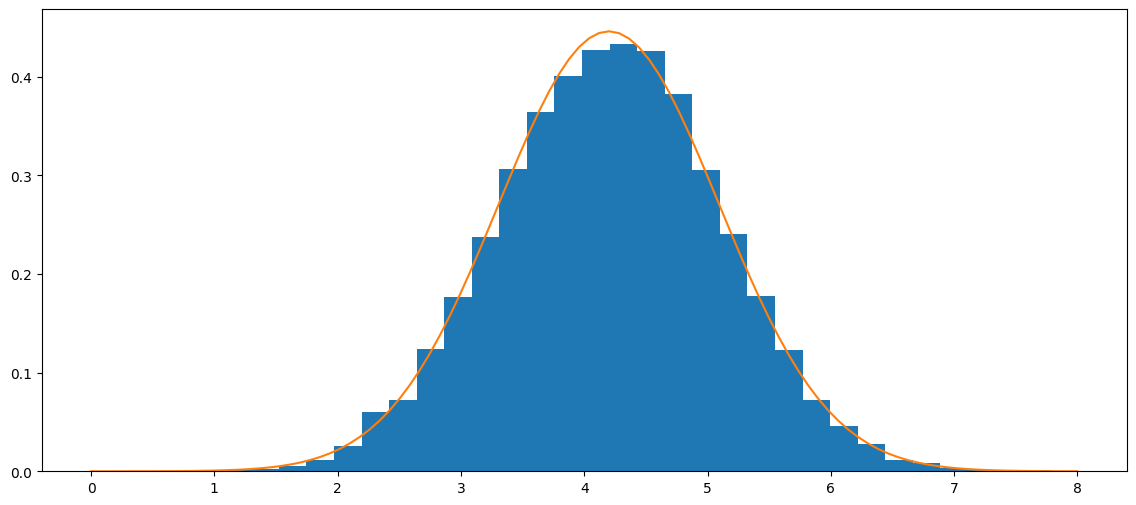

In [ ]:
plt.figure(figsize=(14,6))
plt.hist(prediction_elli, bins=30, density=True)
plt.plot(xx, norm.pdf(xx, mu_pos, sigma_pos))
plt.show()